# Extraction des données

## 1- Importation des modules de base

In [75]:
import pandas as pd
import numpy as np

from datetime import timedelta
from PIL.Image import *
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## 2- Extraction de jeu de données

In [76]:
data = pd.read_csv("./ressources/images/batiments.csv",delimiter = ';', header=None)
data.columns = ["ID","Label"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2000 non-null   int64 
 1   Label   2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


# Opération sur les données

## 1- Répartition des données

<AxesSubplot: xlabel='Label', ylabel='count'>

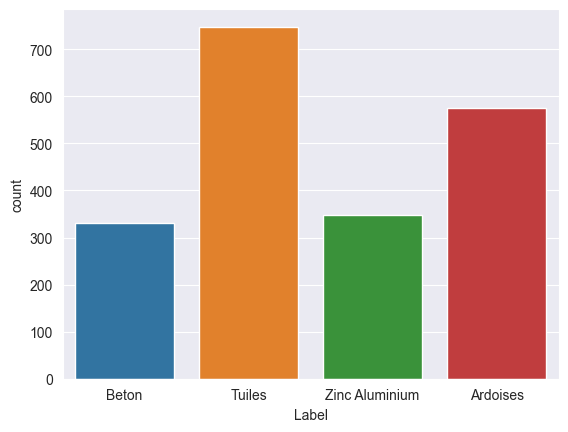

In [77]:
sns.countplot(x='Label',data=data,label="Nombre")

## 2- Ajout de colonnes au dataset avec la moyenne RGB du chunk central de X*X pixels

### Choix de la taille du chunk central qui sera analysé

In [78]:
CHUNK_SIZE = 16

In [79]:
def read_pixel_chunk(chunk_size = 16):
    r = []
    v = []
    b = []
    for image in data["ID"]:
        im = open("./ressources/images/"+str(image)+".jpg")
        (rouge, vert, bleu) = (0,0,0)
        #On fait la moyenne pour chaque pixel du bloc central de 16x16
        for x in range(chunk_size):
            for y in range(chunk_size):
                (rouge, vert, bleu) = (x + y for x, y in zip((rouge, vert, bleu), im.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
        im.close()
        (rouge, vert, bleu) = (round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5))
        r.append(rouge)
        v.append(vert)
        b.append(bleu)
    return r,v,b

On analyse la moyenne RGB du bloc central de 16 par 16 pixels.
Il faut maintenant ajouter ces colonnes au dataset :

In [80]:
results = read_pixel_chunk(CHUNK_SIZE)
data["rouge"] = results[0]
data["vert"] = results[1]
data["bleu"] = results[2]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2000 non-null   int64  
 1   Label   2000 non-null   object 
 2   rouge   2000 non-null   float64
 3   vert    2000 non-null   float64
 4   bleu    2000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 78.2+ KB


## 3- Création des dataset

On va sélectionner aléatoirement 75% d'individus de chaque matériau pour créer le jeu d'apprentissage et les 25% restants serviront à tester notre modèle.

In [81]:
data_tuiles = data[data['Label']== 'Tuiles' ]
data_zinc = data[data['Label']== 'Zinc Aluminium' ]
data_ardoises = data[data['Label']== 'Ardoises' ]
data_beton = data[data['Label']== 'Beton' ]

In [82]:
learning_df = pd.concat([data_tuiles.sample(frac=0.75, random_state=1),data_zinc.sample(frac=0.75, random_state=1),data_ardoises.sample(frac=0.75, random_state=1),data_beton.sample(frac=0.75, random_state=1)] , ignore_index=True)
test_df = data.drop(learning_df.index)

In [83]:
learning_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1500 non-null   int64  
 1   Label   1500 non-null   object 
 2   rouge   1500 non-null   float64
 3   vert    1500 non-null   float64
 4   bleu    1500 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 58.7+ KB


# Algorithme

## 1- Analyse des composantes RGB de chaque matériau de learning dataset

On fait la moyenne RGB de chaque type de matériau pour avoir une estimation des composantes de ce dernier.

In [84]:
def avg_materiau():
    learning_tuiles = learning_df[learning_df['Label']== 'Tuiles' ]
    learning_zinc = learning_df[learning_df['Label']== 'Zinc Aluminium' ]
    learning_ardoises = learning_df[learning_df['Label']== 'Ardoises' ]
    learning_beton = learning_df[learning_df['Label']== 'Beton' ]

    avg_tuile = [learning_tuiles["rouge"].mean(),learning_tuiles["vert"].mean(),learning_tuiles["bleu"].mean()]
    avg_zinc = [learning_zinc["rouge"].mean(),learning_zinc["vert"].mean(),learning_zinc["bleu"].mean()]
    avg_ardoise = [learning_ardoises["rouge"].mean(),learning_ardoises["vert"].mean(),learning_ardoises["bleu"].mean()]
    avg_beton = [learning_beton["rouge"].mean(),learning_beton["vert"].mean(),learning_beton["bleu"].mean()]
    print(avg_tuile,avg_zinc,avg_ardoise,avg_beton)
    return avg_tuile,avg_zinc,avg_ardoise,avg_beton

## 2- Prediction du type de toit d'un bâtiment

In [85]:
avg = avg_materiau()
classes = ["Tuiles","Zinc Aluminium", "Ardoises","Beton"]

[2734.8204099821746, 2469.956662210339, 2363.9938725490197] [2316.2588942307693, 2432.8908653846156, 2498.0774038461536] [1693.9720127610208, 1756.8449825986079, 1928.417488399072] [2114.2631048387098, 2113.5234375, 2114.0372983870966]


In [86]:
def euclidean_distance(ind_1, ind_2):
    ''' Calcule la distance euclidienne entre 2 individus'''
    distance = [(a - b)**2 for a, b in zip(ind_1, ind_2)]
    distance = np.sqrt(sum(distance))
    return distance

In [87]:
def Type_de_toit_predit(image_a_predire,chunk_size):
    image = open("./ressources/images/"+str(image_a_predire)+".jpg")
    [rouge, vert, bleu] = [0, 0, 0]
    # On fait la moyenne pour chaque pixel du bloc central de 16x16
    for x in range(chunk_size):
        for y in range(chunk_size):
            [rouge, vert, bleu] = (x + y for x, y in zip((rouge, vert, bleu), image.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
    image.close()
    [rouge, vert, bleu] = [round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5)]

    distances = [euclidean_distance([rouge, vert, bleu],i) for i in avg]
    return classes[np.argmin(distances)]

Prédiction du type de toît de l'image à prédire de manière statistique.

## 3- Score

In [88]:
def score(avg,chunk_size=16):
    im_prediction = [0,0,0,0]
    im_true = [0,0,0,0]
    conf_matrix = [[0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0]]
    print("Validation en cours")
    for image in test_df.index:
        # Image test = (ID,type,lien)
        identified_as = Type_de_toit_predit(test_df["ID"][image],chunk_size)
        # On modifie la matrice de confusion en fonction du resultat
        # On classe de cette maniere : beton,tuiles,ardoises,zinc
        x,y = classes.index(test_df["Label"][image]),classes.index(identified_as)
        conf_matrix[x][y] += 1

    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d')
    plt.show()
    return round((conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2] + conf_matrix[3][3]) / len(test_df) * 100 , 4), conf_matrix

Validation en cours


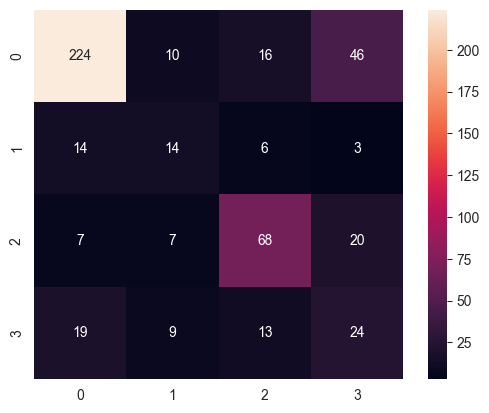

66.0 %


In [89]:
sc = score(avg,CHUNK_SIZE)
print(sc[0],"%")